In [1]:
# calculating
import railrad
import numpy as np
from h5py import File
from scipy.special import hankel2

# plotting
import plotly.graph_objects as go
from IPython.display import Image



# Efficient 2.5D via pre-calculated transfer functions: comparison to analytical solution

In this notebook we compare a numerical approach to solving the acoustic radiation from an infinitely long, cylindrical structure to 100 receiver points arranged in an off-center circle around the structure. The structure is exciting the air around it by 'breathing', moving its surface in- and outwards. The in- and outward motion at each point on the surface is to correspond to the velocity that air would have at that location, if excited by a breathing line monopole without the presence of the structure. This way, the sound field around the structure should closely resemble the sound field that said line monopole produces.
A comparison of both sound fields is carried out for several frequencies and different wavelengths along the line monopole.

## Load Database

The Database `circle_demo.hdf5` contains pre-calculated acoustic transfer functions from a circular cross-section (think: tube or cylinder) to receiver positions located in a second circle in the cross-sectional plane.

In [2]:
DB = railrad.railrad.Database('circle_demo.hdf5')

Successfully loaded the database.


We store the locations of the source nodes and receiver nodes

In [3]:
receiver_coords = DB.receiver_coordinates
source_coords = DB.source_coordinates
normal_vectors = DB.normal_vectors

## Define frequency and wavenumber spectra

In [4]:
frequencies = np.linspace(10,1000,20)
nf = len(frequencies)
jomega = 1j * 2 * np.pi * frequencies

wavenumbers = np.array([DB.k0, 0.25, 0.5, 1, 2, 4, 8])
nk = len(wavenumbers)

rho = 1.2
c = 343

## Set up the database

... by defining the frequency and wavenumber spectra that we want to use in our comparison.

In [5]:
wavenumber_distribution_at_each_frequency = np.repeat(wavenumbers[np.newaxis, :], nf, axis=0)
DB.setup(f=frequencies, k=wavenumber_distribution_at_each_frequency, receiver_nodes=[], source_nodes=[])

## Check the setup

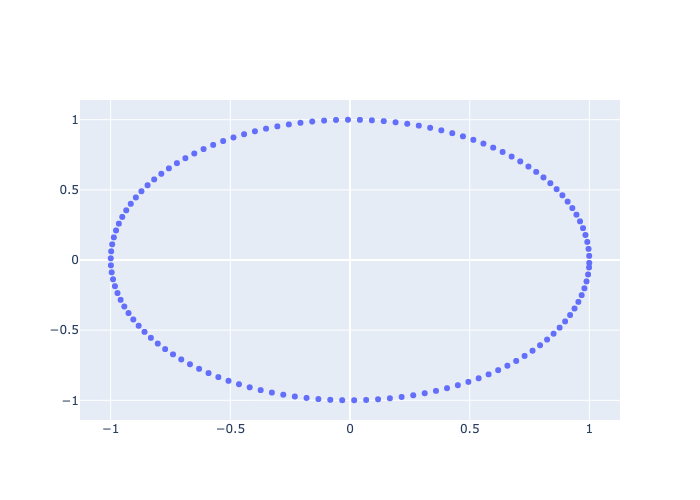

In [6]:
Image(go.Figure([
    go.Scatter(x=DB.source_coordinates[:,0], y=DB.source_coordinates[:,1], text=DB.source_nodes, mode='markers', name='sources'),
]).to_image())

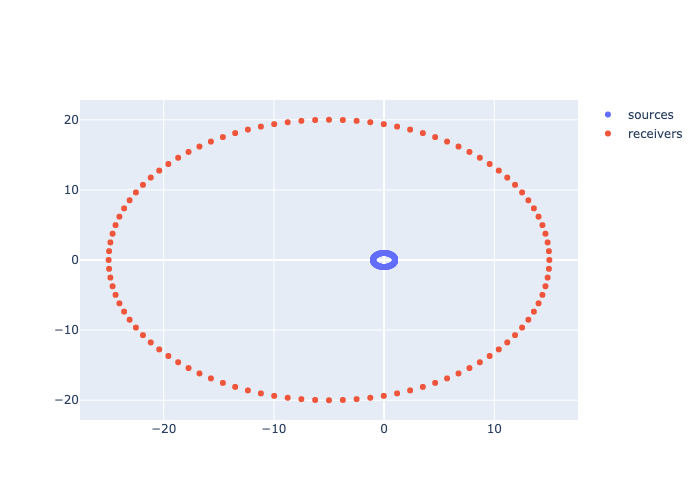

In [7]:
Image(go.Figure([
    go.Scatter(x=DB.source_coordinates[:,0], y=DB.source_coordinates[:,1], text=DB.source_nodes, mode='markers', name='sources'),
    go.Scatter(x=DB.receiver_coordinates[:,0], y=DB.receiver_coordinates[:,1], text=DB.receiver_nodes, mode='markers', name='receivers')
]).to_image())

## Analytical model

The radiation in 2D is modelled via Bessel and Hankel functions, see e.g. *P. Morse and K. U. Ingard, Theoretical Acoustics. Princeton University Press, 1987.* or *T. Wu, Boundary Element Acoustics. WIT Presss, 2000.* for derivation of the analytical model.



In [8]:
mono_coord = np.array([0, 0])
# the coordinate needs to be in the 'structure'-circle, check that here:
assert(np.sqrt(np.sum(mono_coord**2)<1))

wavenumber_in_air = 2 * np.pi * frequencies / c
alpha = np.sqrt(np.repeat(wavenumber_in_air[:, np.newaxis], nk, axis=1)**2 - wavenumbers**2)

<ipython-input-8-32edff69e06c>:6: RuntimeWarning:

invalid value encountered in sqrt



We get the `invalid value` `RuntimeWarning` from `numpy.sqrt`, but that is fine: when the value under the square root is smaller than 0, no far-field radiation occurs, and as long as we are not interested in the near-field radiation, we can just ignore these frequency/wavenumber combinations.

### Calculating the surface velocity on the structure

In [9]:
vector_to_sourcepoints = source_coords - mono_coord
radius_to_sourcepoints = np.sqrt(np.sum(vector_to_sourcepoints**2, axis=1))
kr_sources = np.einsum('fk,r -> fkr', alpha, radius_to_sourcepoints)
normal_contribution = np.einsum('ab, a -> ab', vector_to_sourcepoints, 1 / radius_to_sourcepoints)
dr_dn = np.einsum('ij, ij -> i', normal_contribution,  normal_vectors)

p_sourcepoints = -1j/4 * hankel2(0, kr_sources)

v_sourcepoints = np.einsum('fk, fkr, r, f -> fkr', 1j*alpha/4,
                           hankel2(1, kr_sources), dr_dn, 1/jomega/rho)
v_sourcepoints = np.nan_to_num(v_sourcepoints, nan=1)

### Calculating the complex pressure at the receivers

In [10]:
vector_to_fieldpoints = receiver_coords - mono_coord
radius_to_fieldpoints = np.sqrt(np.sum(vector_to_fieldpoints**2, axis=1))
kr_fp = np.einsum('fk, r -> fkr', alpha, radius_to_fieldpoints)
p_fieldpoints = -1j/4 * hankel2(0, kr_fp)

## Calculate the complex sound pressure via superposition of acoustic transfer functions

In [11]:
Vn = v_sourcepoints[:, :, np.newaxis, :]  # transform to correct shape
DB.superpose(Vn)

/Users/jannik/Projects/phd/wfe/railrad/railrad/helpers.py:34: RuntimeWarning:

invalid value encountered in sqrt



## Plot pressure in a receiver point

<ipython-input-12-a0a92894629c>:4: RuntimeWarning:

divide by zero encountered in log10



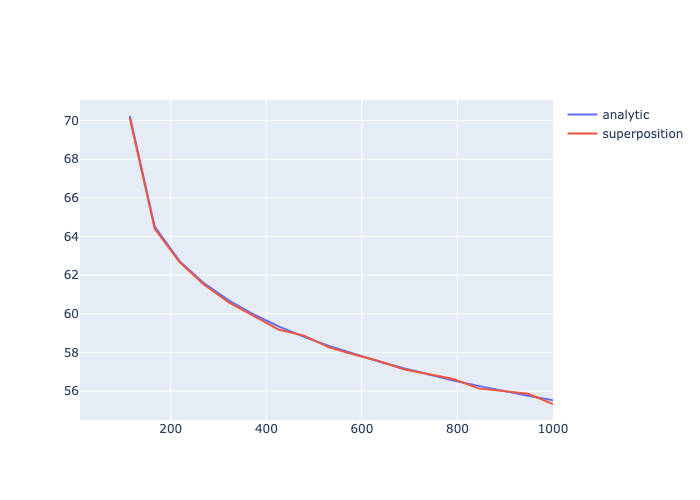

In [12]:
ki = 4
Image(go.Figure([
    go.Scatter(x=frequencies, y=20*np.log10(np.abs(p_fieldpoints[:,ki,20])/2e-5), name='analytic'),
    go.Scatter(x=frequencies, y=20*np.log10(np.abs(DB.response[:,ki,0,20])/2e-5), name='superposition')
]).to_image())

The predicted pressure at the receiver point should be similar for both calculations. Higher accuracy can be achieved by a closer spaced frequency spectrum in the database, but the question is as always: how accurate is accurate enough?